<h2><center>Explorative Datenanalyse</center></h2> 

***

### Import

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud
from collections import Counter


In [5]:
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\sophi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sophi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sophi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\sophi\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sophi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
df_fake_news = pd.read_csv("hf://datasets/newsmediabias/fake_news_elections_labelled_data/cleaned_fakenewsdata.csv")

c:\Users\sophi\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
df_fake_news.head()

,text,label
0,""""""" Study in journal , Nature Communications :...",REAL
1,""""""" Zelensky told the council that he was ther...",REAL
2,""""""" Central bankers and bureaucrats are seizin...",REAL
3,""""""" Last updated on .From the section Swimming...",REAL
4,THE discussion in the Morning Star and elsewhe...,REAL


### Distribution

In [9]:
labels = df_fake_news['label'].value_counts()
print(f'Label Distribution:\n {labels}')

Label Distribution:
 label
REAL    6790
FAKE    2723
Name: count, dtype: int64


Der Datensatz ist unbalanced, da es deutlich mehr echte Nachrichten (REAL) als gefälschte Nachrichten (FAKE) gibt. Probleme könnten sein, dass die ML-Modelle möglicherweise die Mehrheitsklasse (REAL) öfter vorhersagt.

### Preprocessing

In [13]:
class NLTKTokenizer():
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()

    def transform(self, X):
        # Tokenization
        return X.apply(self.tokenize)

    def tokenize(self, text):
        # Normalization
        text = re.sub(r'\W', ' ', str(text))  # only alphanumeric characters
        
        tokens = word_tokenize(text.lower())  
        
        # Stopwords 
        filtered_tokens = [t for t in tokens if t not in self.stop_words and t not in string.punctuation]

        # Lemmatization (+ POS-Tagging)
        lemmatized_tokens = [self.lemmatize_with_pos(token, pos) for token, pos in pos_tag(filtered_tokens)]
        
        return ' '.join(lemmatized_tokens)

    def lemmatize_with_pos(self, token, pos):
        # convert NLTK-POS-Tags in WordNet-POS-Tags
        pos = self.get_wordnet_pos(pos)
        return self.lemmatizer.lemmatize(token, pos=pos) if pos else self.lemmatizer.lemmatize(token)

    def get_wordnet_pos(self, nltk_pos):
        # convert NLTK-POS-Tags in WordNet-POS-Tags
        if nltk_pos.startswith('J'):
            return 'a'  # adjectives
        elif nltk_pos.startswith('V'):
            return 'v'  # verbs
        elif nltk_pos.startswith('N'):
            return 'n'  # nouns
        elif nltk_pos.startswith('R'):
            return 'r'  # adverbs
        else:
            return None 

In [14]:
tokenizer = NLTKTokenizer()

In [15]:
df_fake_news['cleaned_text'] = tokenizer.transform(df_fake_news['text'])

### Top 5 words per category

In [18]:
def get_top_n_words(text_series, n=5):
    # Flache Liste erstellen
    all_words = [word for text in text_series for word in text.split()]
    word_counts = pd.Series(all_words).value_counts()
    return word_counts.head(n)

# Top-Wörter für "real"
real_texts = df_fake_news[df_fake_news['label'] == 'REAL']['cleaned_text']
print("Top-Wörter für 'real':\n", get_top_n_words(real_texts))

# Top-Wörter für "fake"
fake_texts = df_fake_news[df_fake_news['label'] == 'FAKE']['cleaned_text']
print("Top-Wörter für 'fake':\n", get_top_n_words(fake_texts))

Top-Wörter für 'real':
 say      19500
year      7618
state     7214
u         6891
one       6179
Name: count, dtype: int64
Top-Wörter für 'fake':
 russian    8298
weak       6614
loser      6585
coward     6577
say        3315
Name: count, dtype: int64


Die häufigsten Wörter in echten Nachrichten (REAL) wie say, year oder state sind eher formal und sachlich, während in den gefälschten Nachrichten (FAKE) emotionale und polarisierende Begriffe wie russian, weak, loser oder coward verwendet werden.

### Wordclouds

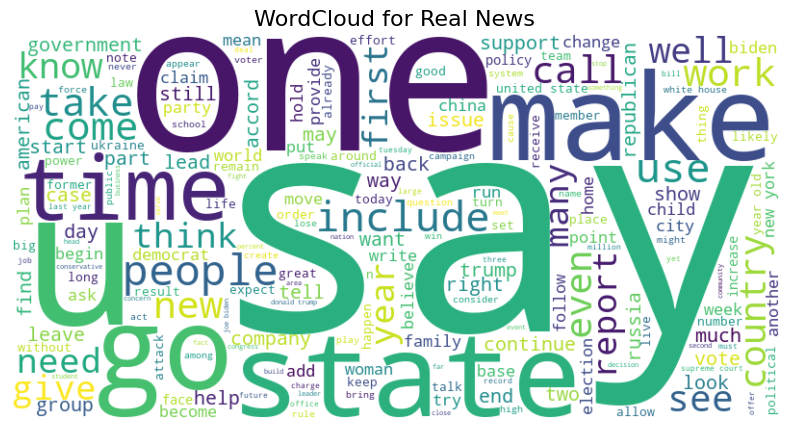

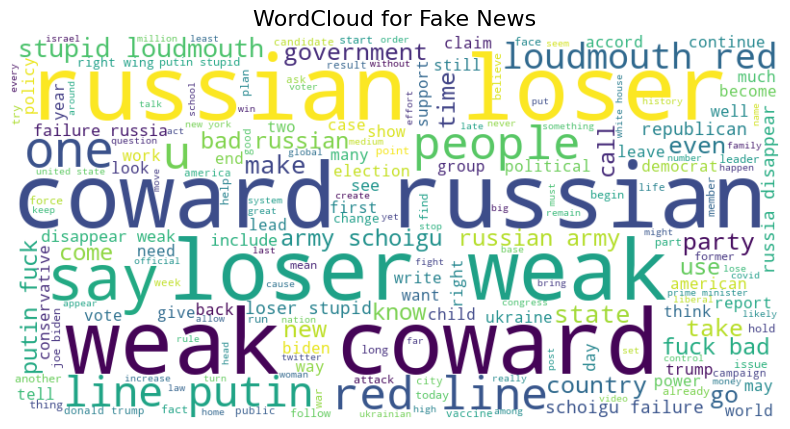

In [19]:
# Wordclouds erzeugen
def plot_wordcloud(text_series, title):
    all_words = ' '.join(text_series)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=16)
    plt.axis('off')
    plt.show()

plot_wordcloud(real_texts, 'WordCloud for Real News')
plot_wordcloud(fake_texts, 'WordCloud for Fake News')

### Hot topics per category

In [21]:
def get_topics(text_series, n_topics=5, n_top_words=10):
    vectorizer = CountVectorizer(max_features=5000, stop_words='english')
    dtm = vectorizer.fit_transform(text_series)
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda.fit(dtm)
    
    topics = []
    for idx, topic in enumerate(lda.components_):
        topic_words = [vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-n_top_words:]]
        topics.append("Topic {}: ".format(idx+1) + ", ".join(topic_words))
    return topics

print("Themen für 'REAL':\n", '\n'.join(get_topics(real_texts)))
print("Themen für 'FAKE':\n", '\n'.join(get_topics(fake_texts)))


Themen für 'REAL':
 Topic 1: woman, know, news, time, make, police, like, year, people, say
Topic 2: climate, time, like, energy, year, make, company, new, use, say
Topic 3: china, war, state, party, government, russian, country, ukraine, russia, say
Topic 4: court, biden, vote, house, president, election, republican, state, trump, say
Topic 5: new, percent, high, million, people, time, 19, covid, year, say
Themen für 'FAKE':
 Topic 1: people, war, military, make, time, ukrainian, russia, russian, ukraine, say
Topic 2: right, election, say, state, president, house, party, biden, trump, republican
Topic 3: russia, loudmouth, line, red, stupid, putin, coward, loser, weak, russian
Topic 4: health, report, child, say, year, 19, death, people, vaccine, covid
Topic 5: war, state, new, leave, country, year, say, right, government, party


Die Themenanalyse zeigt, dass echte Nachrichten (REAL) häufig Themen wie Politik, Klimawandel, Wirtschaft und Gesundheit behandeln, während gefälschte Nachrichten (FAKE) oft emotional aufgeladene Inhalte, polarisierende Sprache und kontroverse Themen wie Krieg, politische Spaltung und persönliche Angriffe fokussieren, was die manipulative Natur von Fake News unterstreicht.

In [23]:
def get_top_tfidf_words(text_series, n=10):
    vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(text_series)
    feature_names = vectorizer.get_feature_names_out()
    avg_tfidf_scores = np.asarray(tfidf_matrix.mean(axis=0)).flatten()
    top_indices = avg_tfidf_scores.argsort()[-n:][::-1]
    top_words = [(feature_names[i], avg_tfidf_scores[i]) for i in top_indices]
    return top_words

print("Top TF-IDF-Wörter für 'REAL':\n", get_top_tfidf_words(real_texts))
print("Top TF-IDF-Wörter für 'FAKE':\n", get_top_tfidf_words(fake_texts))

Top TF-IDF-Wörter für 'REAL':
 [('say', 0.0429174958852352), ('year', 0.021434586740402013), ('state', 0.021206682605419983), ('party', 0.021048696475543548), ('new', 0.018503906017114366), ('trump', 0.018090450682706385), ('people', 0.017499939165063445), ('president', 0.017164773275696866), ('election', 0.016955172784855282), ('make', 0.016084773803584737)]
Top TF-IDF-Wörter für 'FAKE':
 [('party', 0.03655382140513352), ('say', 0.02794210262743333), ('republican', 0.02764684998388655), ('right', 0.02468348695211471), ('state', 0.021963293277882108), ('election', 0.021787225247242564), ('biden', 0.021153942250438294), ('house', 0.02109569422080466), ('trump', 0.020787046683912378), ('president', 0.019436396600573367)]


TF-IDF zeigt, wie wichtig ein Wort für ein bestimmtes Dokument ist und wie oft ein Wort in einem Dokument vorkommt (tf). IDF gewichtet Wörter, die in vielen Dokumenten häufig vorkommen, niedriger, da sie weniger aussagekräftig sind (z. B. the; is). Hohe TF-IDF-Werte deuten darauf hin, dass ein Wort in einem Dokument häufig vorkommt. 

Wörter in echten Nachrichten (REAL) mit den höchsten TF-IDF-Werten (say, year, state, party, new, trump) spiegeln eine Berichterstattung wider, die sich auf allgemeine Nachrichten und politisch relevante Themen konzentriert. Beispiel: say könnte darauf hindeuten, dass echte Nachrichten oft Zitate oder Berichte von offiziellen Stellen enthalten. 

Wörter in gefälschten Nachrichten (FAKE) mit hohen TF-IDF-Werten (republican, right, election, biden) deuten darauf hin, dass gefälschte Nachrichten oft Themen wie politische Parteien oder Persönlichkeiten polarisieren.


In [27]:
def word_length_stats(text_series):
    lengths = [len(word) for text in text_series for word in text.split()]
    return {
        'mean': np.mean(lengths),
        'median': np.median(lengths),
        'std': np.std(lengths),
        'max': np.max(lengths),
        'min': np.min(lengths)
    }

print("Wortlängen-Statistiken für 'REAL':\n", word_length_stats(real_texts))
print("Wortlängen-Statistiken für 'FAKE':\n", word_length_stats(fake_texts))

Wortlängen-Statistiken für 'REAL':
 {'mean': 5.904402718661176, 'median': 6.0, 'std': 2.3928605743909275, 'max': 172, 'min': 1}
Wortlängen-Statistiken für 'FAKE':
 {'mean': 5.960215847623005, 'median': 6.0, 'std': 2.3717185103594898, 'max': 34, 'min': 1}


Die durchschnittliche Wortlänge in echten Nachrichten ("REAL") mit 5,90 Zeichen ist nahezu identisch mit der in gefälschten Nachrichten ("FAKE") (5,96 Zeichen). Beide Kategorien haben eine Medianlänge von 6 Zeichen und ähnliche Standardabweichungen. Echte und gefälschte Nachrichten unterscheiden sich also kaum in Bezug auf die Wortlänge.

In [26]:
def pos_tag_distribution(text_series):
    pos_counts = Counter()
    for text in text_series:
        tokens = word_tokenize(text)
        pos_tags = [pos for word, pos in pos_tag(tokens)]
        pos_counts.update(pos_tags)
    return pos_counts.most_common()

print("POS-Tag-Verteilung für 'real':\n", pos_tag_distribution(real_texts))
print("POS-Tag-Verteilung für 'fake':\n", pos_tag_distribution(fake_texts))

POS-Tag-Verteilung für 'real':
 [('NN', 814304), ('JJ', 334662), ('VBP', 101504), ('RB', 81540), ('CD', 70308), ('VB', 51992), ('NNS', 36161), ('IN', 31365), ('VBD', 22448), ('MD', 14535), ('VBZ', 9091), ('VBN', 8046), ('VBG', 7309), ('NNP', 3308), ('JJS', 3243), ('DT', 3052), ('FW', 2941), ('JJR', 2612), ('RBR', 2568), ('CC', 1113), ('RP', 741), ('WP$', 457), ('$', 365), ('WDT', 287), ('WRB', 254), ('WP', 241), ('PRP', 236), ('RBS', 236), ('UH', 155), ('TO', 135), ('PRP$', 56), ('NNPS', 27), ('POS', 26), ('EX', 18), ('SYM', 9), ('PDT', 3), ("''", 1)]
POS-Tag-Verteilung für 'fake':
 [('NN', 272314), ('JJ', 128179), ('VBP', 29732), ('RB', 27478), ('CD', 19615), ('VB', 15693), ('NNS', 10548), ('IN', 9661), ('VBD', 6946), ('MD', 4282), ('VBZ', 3022), ('VBN', 2456), ('VBG', 2438), ('DT', 1051), ('NNP', 1015), ('JJS', 893), ('FW', 886), ('JJR', 697), ('RBR', 693), ('CC', 361), ('RP', 242), ('WP$', 157), ('WDT', 126), ('$', 114), ('WRB', 106), ('PRP', 88), ('WP', 83), ('RBS', 76), ('UH', 41)

POS-Tags beschreiben die grammatikalischen Kategorien von Wörtern, wie z. B. Substantive (NN), Verben (VB), Adjektive (JJ) oder Adverbien (RB). Die POS-Tag-Verteilung zeigt, wie häufig bestimmte Wortarten in einem Text vorkommen, um den Sprachstil und die Struktur des Textes zu analysieren.

NN (Noun, Singular): Häufige Verwendung von Substantiven deutet auf eine faktenorientierte und beschreibende Sprache hin.
JJ (Adjective): Adjektive zeigen oft Meinungen oder Bewertungen an, insbesondere in emotionaler oder polarisierender Sprache.
VBP (Verb, Present Tense): Die Verwendung von Verben in der Gegenwartsform kann auf eine aktive Sprache hindeuten.

Die POS-Tag-Verteilung zeigt, dass sowohl echte Nachrichten ("REAL") als auch gefälschte Nachrichten ("FAKE") von Substantiven (NN) dominiert werden. Echte Nachrichten enthalten jedoch deutlich mehr Verben (z. B. VBP, VB) und Adjektive (JJ), was auf eine komplexere und variantenreichere Sprache hindeutet, während gefälschte Nachrichten tendenziell eine reduzierte sprachliche Vielfalt und kürzere Sätze aufweisen.